# Inception

This is a first basic notebook to make sure that things are generally running.

In [1]:
import os.path
import io
import itertools

import numpy as np
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3

from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import matplotlib

from astropy.io import fits
from astropy.table import Table

from decimal import Decimal
import math

directory = '/opt/data/NeuralNetwork/dssi_dwarfs/'
info_file = os.path.join(directory, 'stamps2.ecsv')

Using TensorFlow backend.


## User Methods

In [2]:
def display_image(position):
    image = train['features'][position].squeeze()
    minim, maxim = np.min(image), np.max(image)
    image = (image - minim) / (maxim - minim)
    plt.figure(1)
    plt.clf()
    plt.title('Example {}. Label: {}'.format(position, train['labels'][position]))
    plt.imshow(image[:,:,:3].astype(np.float64), cmap=plt.cm.gray_r)


def scale_column(column, value):
    vmin, vmax = column_scaling[column]['min'], column_scaling[column]['max']
    return np.clip((value - vmin) / (vmax - vmin), 0, 1)


def fexp(number):
    """
    Get the exponent
    """
    (sign, digits, exponent) = Decimal(number).as_tuple()
    return len(digits) + exponent - 1


def roundup(number):
    """
    Round the number up to the nearest factor, but in a nice way
    """
    theexp = fexp(number)

    if theexp < 0:
        return math.ceil(number * 10**abs(theexp)) / (10**abs(theexp))
    else:
        return math.ceil(number * 10**abs(theexp-2)) / (10**abs(theexp-2))
    return
vroundup = np.vectorize(roundup)

def rounddown(number):
    """
    Round down to the nearest factor, but in a nice way
    """
    theexp = fexp(number)

    if theexp < 0:
        return math.floor(number / 10**abs(theexp)) * (10**abs(theexp))
    else:
        return math.floor(number * 10**abs(theexp-2)) / (10**abs(theexp-2))
    return
vrounddown = np.vectorize(rounddown)

def random_subsets(thelist, subsets, probabilities=None):
    """
    Create random sugesets of data.

    I need to check to make sure the data exists and is non-zero as well
    """
    used = []

    if probabilities is None:
        probabilities = np.ones(len(thelist))
        
    
    for subset in subsets:
        all_used = list(itertools.chain(*used))

        possible = list(set(thelist) - set(all_used))

        probabilities_subset = probabilities[possible]
        probabilities_subset = probabilities_subset / np.sum(probabilities_subset)

        thesublist = np.random.choice(possible, subset, replace=False, p=probabilities_subset)

        used.append(thesublist)

    return used


# Step 1 : Define a function to get input (can be subsetting a numpy array, pandas dataframe, reading in from disk etc.) :
def get_input(path):
    
    f = fits.open(os.path.join(directory, path))
    img = f[0].data.transpose((1, 2, 0))[16:-16,16:-16,:3] # move channels to last.
    return(img)


# Step 2 : Define a function to get output :
def get_output(dwarf_table_row, columns):    
    return np.array([scale_column(c, dwarf_table_row[c]) for c in columns])

# Step 3 : Define a function to preprocess input :
def preprocess_input(image):
    
#     --- Rescale Image
#     --- Rotate Image
#     --- Resize Image
#     --- Flip Image
#     --- PCA etc.
    
    return(image)


# Step 4 : Bring everything together to define your generator :
def image_generator(dwarfs_table, row_indices, batch_size = 64):
    """
    Need to pass in dwarfs_table
    indices over which we will do a random choice
    """
    while True:
        # Select files (paths/indices) for the batch
        batch_dwarfs_rows = np.random.choice(a=dwarfs_table[row_indices], size=batch_size, replace=False)

        batch_input = []
        batch_output = [] 

        # Read in each input, perform preprocessing and get labels
        for row in batch_dwarfs_rows:
            data = get_input(row['filename'])
            output = get_output(row, columns)

            #input = preprocess_input(image=input)
            batch_input += [ data ]
            batch_output += [ output ]

        # Return a tuple of (input,output) to feed the network
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        
        #batch_x = vgg19_preprocess_input(batch_x)
        #batch_x = (batch_x - np.min(batch_x)) / (np.max(batch_x) - np.min(batch_x))

        yield batch_x, batch_y



## Load the Information File

In [3]:
crop = (224, 224)

# table_object = bucket.Object('stamps2.ecsv')
# dwarfs_table = Table.read(io.BytesIO(table_object.get()['Body'].read()), format='ascii.ecsv')
dwarfs_table = Table.read(info_file, format='ascii.ecsv')
dwarfs_table

<Table length=12558>
                      filename                       logmass ... noise_z noise_y
                       str52                         float64 ... float64 float64
---------------------------------------------------- ------- ... ------- -------
stamps2/d14.79_m7.45_re0.35_feh-1.2_age10.0_HSC.fits  7.4485 ...  0.0349  0.0164
stamps2/d12.46_m6.72_re0.44_feh-1.5_age12.6_HSC.fits  6.7190 ...  0.0245  0.0281
 stamps2/d9.81_m8.47_re0.84_feh-1.0_age12.3_HSC.fits  8.4725 ...  0.0251  0.0167
 stamps2/d14.38_m5.08_re0.47_feh-2.0_age7.0_HSC.fits  5.0823 ...  0.0365  0.0319
stamps2/d11.95_m8.55_re1.34_feh-1.0_age13.7_HSC.fits  8.5475 ...  0.0372  0.0224
  stamps2/d9.74_m5.33_re0.46_feh-1.8_age7.7_HSC.fits  5.3289 ...  0.0179  0.0166
stamps2/d10.94_m5.00_re0.95_feh-1.5_age13.2_HSC.fits  5.0040 ...  0.0202  0.0344
stamps2/d12.95_m5.07_re0.21_feh-2.0_age11.4_HSC.fits  5.0731 ...  0.0233  0.0198
 stamps2/d7.03_m6.23_re0.47_feh-1.8_age11.3_HSC.fits  6.2316 ...  0.0374  0.0274
stamps2/d11.57_m5.17_re0.22_feh-2.0_age11.7_HSC.fits  5.1709 ...  0.0338  0.0230
                                                 ...     ... ...     ...     ...
 stamps2/d3.73_m7.66_re0.45_feh-1.2_age13.1_HSC.fits  7.6571 ...  0.0174  0.0350
 stamps2/d10.51_m5.05_re0.19_feh-2.0_age9.7_HSC.fits  5.0504 ...  0.0291  0.0190
stamps2/d10.23_m8.55_re0.72_feh-1.2_age10.8_HSC.fits  8.5462 ...  0.0320  0.0177
stamps2/d11.71_m6.42_re0.63_feh-1.5_age10.1_HSC.fits  6.4168 ...  0.0397  0.0283
 stamps2/d3.68_m5.31_re0.53_feh-2.0_age14.0_HSC.fits  5.3101 ...  0.0324  0.0192
stamps2/d14.93_m5.67_re0.21_feh-2.0_age12.0_HSC.fits  5.6689 ...  0.0299  0.0189
 stamps2/d11.84_m7.86_re0.43_feh-1.2_age8.2_HSC.fits  7.8559 ...  0.0179  0.0350
  stamps2/d4.90_m7.64_re0.43_feh-1.0_age8.7_HSC.fits  7.6398 ...  0.0163  0.0305
stamps2/d14.13_m5.68_re0.35_feh-1.8_age10.2_HSC.fits  5.6786 ...  0.0234  0.0307
stamps2/d11.39_m8.88_re1.23_feh-1.0_age12.0_HSC.fits  8.8764 ...  0.0161  0.0344

## Setup the Columns of Interest

(array([  4.,   2.,   4.,  10.,  18.,  15.,  18.,  26.,  43.,  28.,  49.,
         50.,  64.,  60.,  79.,  82., 104., 108., 101., 111., 146., 134.,
        161., 171., 176., 196., 234., 244., 256., 291., 287., 326., 314.,
        338., 353., 332., 387., 421., 447., 465., 452., 502., 567., 565.,
        565., 589., 611., 653., 676., 723.]),
 array([ 0.7415  ,  1.026662,  1.311824,  1.596986,  1.882148,  2.16731 ,
         2.452472,  2.737634,  3.022796,  3.307958,  3.59312 ,  3.878282,
         4.163444,  4.448606,  4.733768,  5.01893 ,  5.304092,  5.589254,
         5.874416,  6.159578,  6.44474 ,  6.729902,  7.015064,  7.300226,
         7.585388,  7.87055 ,  8.155712,  8.440874,  8.726036,  9.011198,
         9.29636 ,  9.581522,  9.866684, 10.151846, 10.437008, 10.72217 ,
        11.007332, 11.292494, 11.577656, 11.862818, 12.14798 , 12.433142,
        12.718304, 13.003466, 13.288628, 13.57379 , 13.858952, 14.144114,
        14.429276, 14.714438, 14.9996  ]),
 <a list of 50 Patch ob

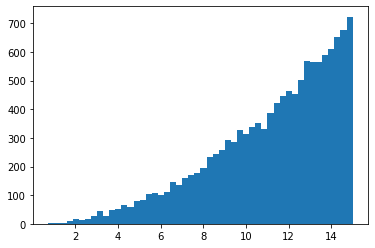

In [4]:
distances = dwarfs_table['distance']
plt.hist(distances, bins=50)

In [5]:
# Calculate the scale factors for each attribute
#columns = ['distance', 'logmass', 'rekpc', 'FeH', 'age']
columns = ['logmass', 'distance']

column_scaling = {}
for column in columns:
  column_scaling[column] = {
      'min': np.percentile(dwarfs_table[column], 0.01), 
      'max': np.percentile(dwarfs_table[column], 99.99)
}

print('Columns Scaling is {}'.format(column_scaling))

Columns Scaling is {'logmass': {'min': 5.0002, 'max': 8.99742329}, 'distance': {'min': 0.86109265, 'max': 14.999248860000002}}


## Load the Data into Test and Train

In [6]:
indices = range(len(dwarfs_table))

# training indices
#distance_norm = scale_column('distance', dwarfs_table['distance'])
counts, bins = np.histogram(dwarfs_table['distance'], np.arange(0, 16))

plookup = (1 / len(counts)) * (1 / counts)
probabilities = np.array([plookup[int(x)] for x in np.floor(dwarfs_table['distance'])])

#out = np.random.choice(dwarfs_table['distance'], 1000, p=probabilities)
#plt.hist(out)

training_test_indices = random_subsets(indices, [5000, 100, 25], probabilities=probabilities)
training_indices, validation_indices, test_indices = training_test_indices

In [24]:
EPOCHS = 20
BATCH_SIZE = 32

model = InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for l in model.layers:
    l.trainable = False

x = model.output

# Re-add the layers here, with new weights.
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(50, activation='relu')(x)
x = layers.Dense(2, activation='linear', name='predictions')(x)
model = keras.Model(inputs=model.inputs, outputs=x)

model.summary()

model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mean_absolute_error', 'mean_squared_error'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_753 (Conv2D)             (None, 111, 111, 32) 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_753 (BatchN (None, 111, 111, 32) 96          conv2d_753[0][0]                 
__________________________________________________________________________________________________
activation_753 (Activation)     (None, 111, 111, 32) 0           batch_normalization_753[0][0]    
__________________________________________________________________________________________________
conv2d_754

## Train the Neural Network

In [ ]:
train_generator = image_generator(dwarfs_table, training_indices, batch_size=BATCH_SIZE)
validation_generator = image_generator(dwarfs_table, validation_indices, batch_size=BATCH_SIZE)
test_generator = image_generator(dwarfs_table, test_indices, batch_size=BATCH_SIZE)

steps_per_epoch = len(training_indices)//BATCH_SIZE
validation_steps = len(validation_indices)//BATCH_SIZE

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps,
                    shuffle=True, callbacks=[])


Epoch 1/20
  5/156 [..............................] - ETA: 44:25 - loss: 81541771330643598245888.0000 - mean_absolute_error: 80996376013.2066 - mean_squared_error: 81541771330643598245888.0000

## Show Training Output

In [ ]:
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)                                                                                                                                                                                               

plt.figure(2, figsize=[7, 5])
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.legend(['train', 'validation'], fontsize=16)
plt.grid('on')
plt.show()


## Show Results Compared to Truth

In [ ]:
calculated = np.zeros((len(test_indices), len(columns)))
truth = np.zeros((len(test_indices), len(columns)))

for ii, test_indice in enumerate(test_indices):
    row = dwarfs_table[test_indice]
    f = fits.open(os.path.join(directory, row['filename']))

    data = f[0].data.transpose((1, 2, 0))[16:-16, 16:-16, :3] # move channels to last.

    values = model.predict(data[None,:])[0]

    for jj, c in enumerate(columns):
        cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
        values[jj] = values[jj] * (cmax - cmin) + cmin

    calculated[ii] = values
    truth[ii] = [row[c] for c in columns]


plt.figure(3, figsize=[9, 6])
plt.clf()

cs = int(np.ceil(np.sqrt(len(columns))))
rs = int(len(columns) // cs)

for ci, c in enumerate(columns):
    plt.subplot(rs, cs, ci+1)
    plt.plot(truth[:, ci], calculated[:, ci], '.')
    plt.title(c, fontsize=18)
    cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
    plt.xlim((cmin, cmax))
    plt.ylim((cmin, cmax))
    plt.grid('on')
    plt.xlabel('Truth', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.plot([cmin, cmax], [cmin, cmax])


In [ ]:
Ncompare = 500

calculated = np.zeros((Ncompare, len(columns)))
truth = np.zeros((Ncompare, len(columns)))

for ii, test_indice in enumerate(training_indices[:Ncompare]):
    row = dwarfs_table[test_indice]
    f = fits.open(os.path.join(directory, row['filename']))

    data = f[0].data.transpose((1, 2, 0))[16:-16, 16:-16,:3] # move channels to last.

    values = model.predict(data[None,:])[0]

    for jj, c in enumerate(columns):
        cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
        values[jj] = values[jj] * (cmax - cmin) + cmin

    calculated[ii] = values
    truth[ii] = [row[c] for c in columns]


plt.figure(3, figsize=[9, 6])
plt.clf()

cs = int(np.ceil(np.sqrt(len(columns))))
rs = int(len(columns) // cs)

for ci, c in enumerate(columns):
    plt.subplot(rs, cs, ci+1)
    plt.plot(truth[:, ci], calculated[:, ci], '.')
    plt.title(c, fontsize=18)
    cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
    plt.xlim((cmin, cmax))
    plt.ylim((cmin, cmax))
    plt.grid('on')
    plt.xlabel('Truth', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.plot([cmin, cmax], [cmin, cmax])
plt.suptitle('Training Data [Subset]')


In [ ]:
data[None,:].shape